## CODE
#### Imports


In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import MyUtils
from importlib import reload
import UNet
import pickle

#### User Input Data


In [11]:
path_images = "D:\\Work\\Sarbazi\\data\\dataset"
path_masks = "D:\\Work\\Sarbazi\\data\\dataset\\manual segmentation"
batch_size = 4
image_shape = (1024//2, 768//2)

#### Data Generation


In [12]:
MyUtils = reload(MyUtils)
id_all_data = MyUtils.get_id_all_data(path_masks)
id_training_data, id_testing_data = MyUtils.split_train_test_id(id_all_data,testing_share=0.2)
training_data = MyUtils.DataGenerator(path_images, path_masks, id_training_data, batch_size, image_shape)
testing_data = MyUtils.DataGenerator(path_images, path_masks, id_testing_data, 20, image_shape, shuffle=False)

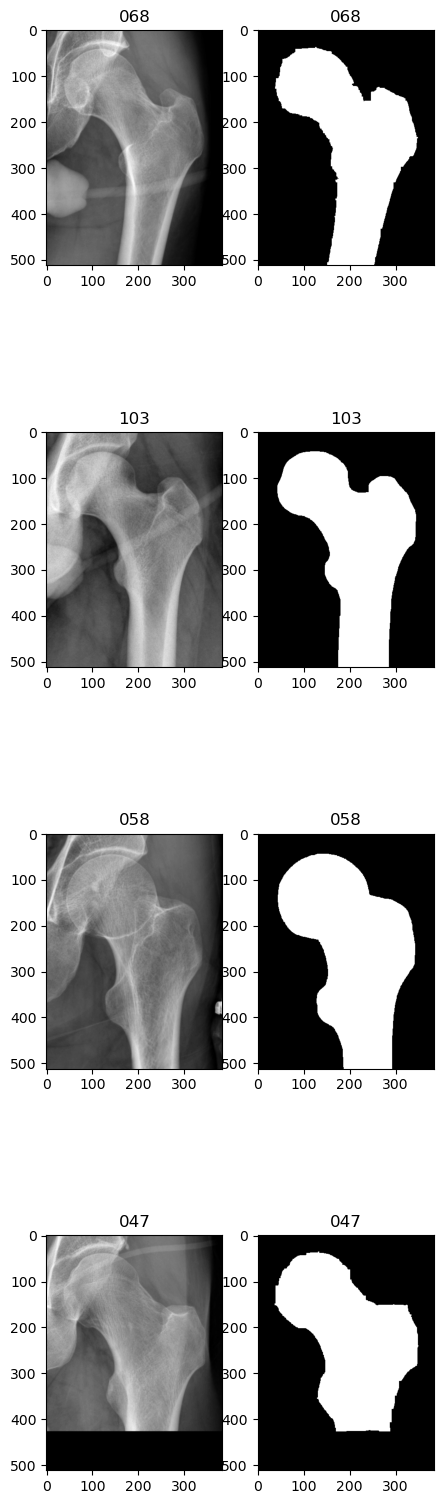

In [13]:
batch_id = 0
sample_batch_image, sample_batch_mask = training_data.__getitem__(batch_id)
img_ids = training_data._get_image_ids(batch_id)
fig, ax = plt.subplots(4, 2, figsize=(5, 20))
for i in range(batch_size):
    ax[i, 0].imshow(sample_batch_image[i,:,:,0],cmap='gray')
    ax[i, 0].set_title(str(img_ids[i]).zfill(3))
    ax[i, 1].imshow(sample_batch_mask[i,:,:,0],cmap='gray')
    ax[i, 1].set_title(str(img_ids[i]).zfill(3))

#### Create U-Net


In [14]:
UNet = reload(UNet)
MyUtils = reload(MyUtils)
UNetModel = UNet.create_UNet((*image_shape,1), (*image_shape,1))
UNetModel.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
# UNetModel.compile(optimizer="adam", loss=MyUtils.dice_coef_loss, metrics=[MyUtils.dice_coef])
UNetModel.summary(line_length=120)

Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_3 (InputLayer)                  [(None, 512, 384, 1)]      0             []                                      
                                                                                                                        
 conv2d (Conv2D)                       (None, 512, 384, 4)        40            ['input_3[0][0]']                       
                                                                                                                        
 conv2d_1 (Conv2D)                     (None, 512, 384, 4)        148           ['conv2d[0][0]']                        
                                                                                                                        
 max_pooling2d (M

In [15]:
UNetModel.fit(training_data, validation_data=testing_data, epochs=50, workers=10)

Epoch 1/50
20/20 [==============================] - 18s 649ms/step - loss: 0.6869 - acc: 0.6271 - val_loss: 0.6275 - val_acc: 0.7374
Epoch 2/50
20/20 [==============================] - 9s 418ms/step - loss: 0.6996 - acc: 0.6249 - val_loss: 0.6888 - val_acc: 0.6162
Epoch 3/50
20/20 [==============================] - 10s 428ms/step - loss: 0.6871 - acc: 0.6166 - val_loss: 0.6814 - val_acc: 0.6152
Epoch 4/50
20/20 [==============================] - 10s 436ms/step - loss: 0.5988 - acc: 0.6157 - val_loss: 0.4851 - val_acc: 0.6160
Epoch 5/50
20/20 [==============================] - 10s 384ms/step - loss: 0.4678 - acc: 0.7027 - val_loss: 0.4622 - val_acc: 0.7017
Epoch 6/50
20/20 [==============================] - 9s 416ms/step - loss: 0.4542 - acc: 0.7738 - val_loss: 0.4089 - val_acc: 0.8474
Epoch 7/50
20/20 [==============================] - 9s 396ms/step - loss: 0.2967 - acc: 0.8772 - val_loss: 0.3444 - val_acc: 0.8781
Epoch 8/50
20/20 [==============================] - 9s 405ms/step - loss

In [16]:
# UNetModel.save_weights('UNetModel_weights.h5')
UNetModel.save('UNetModel.h5', save_traces=True)

In [5]:
# UNetModel.load_weights('UNetModel_weights.h5')
UNetModel = UNet.keras_models.load_model('UNetModel.h5')

In [17]:
batch_id = 0
sample_test_image, sample_test_mask = testing_data.__getitem__(batch_id)
predict_segment = UNetModel.predict(sample_test_image)
predict_segment = (predict_segment>0.5).astype(np.bool_)

1/1 [==============================] - 0s 241ms/step


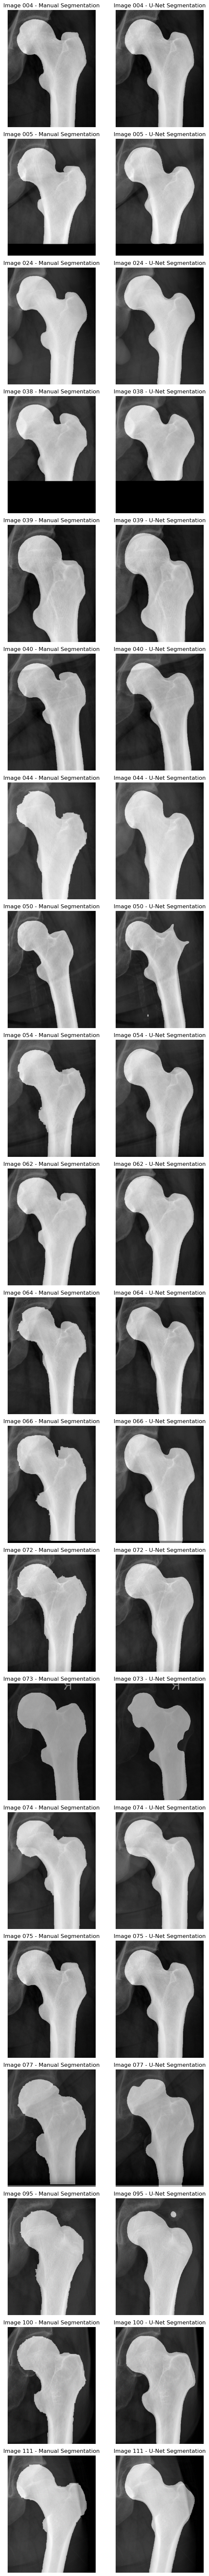

In [18]:
fig, axs = plt.subplots(sample_test_image.shape[0], 2, figsize=(8,100))
titles = [str(i).zfill(3) for i in testing_data._get_image_ids(batch_id)]
for i in range(sample_test_image.shape[0]):
    axs[i,0].imshow(sample_test_image[i,:,:,0], cmap='gray')
    axs[i,0].imshow(sample_test_mask[i,:,:,0],cmap='gray',alpha=0.5)
    axs[i,0].set_title("Image %s - Manual Segmentation" % (titles[i]))
    axs[i,0].axis('off')
    axs[i,1].imshow(sample_test_image[i,:,:,0], cmap='gray')
    axs[i,1].imshow(predict_segment[i,:,:,0],cmap='gray',alpha=0.5)
    axs[i,1].set_title("Image %s - U-Net Segmentation" % (titles[i]))
    axs[i,1].axis('off')
plt.subplots_adjust(hspace=0.1, wspace=0.1)

In [8]:
with open('out.png','wb') as f:
    fig.savefig(f, dpi=600)